In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device= torch.device("cuda"if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [4]:
df=pd.read_csv("data/daily_min_temp.csv",index_col="Date",parse_dates=["Date"])
df

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


# Dataset Splitting

In [5]:
from sklearn.model_selection import train_test_split

In [6]:

ts_train, ts_test = train_test_split(df, test_size=0.2,shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset and Dataloader

In [7]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [8]:
seq_len= 14
bs=32

train_set= TimeSeriesDataset(ts_train,"Temp",seq_len)
trainloader=DataLoader(train_set,batch_size=bs)

test_set=TimeSeriesDataset(ts_test,"Temp",seq_len)
testloader= DataLoader(test_set,batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur and Config

In [15]:
class GRU (nn.Module):
    def __init__(self,input_size,output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.hidden= nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional = True)
        self.fc = nn.Linear(2*hidden_size, output_size)
        
        
    def forward(self,x,hidden):
        x,hidden= self.hidden(x,hidden)
        x= self.fc(x)
        return x,hidden

In [16]:
config = set_config({
    "batch_size" : bs,
    "seq_len" : train_set.n_seq,
    "input_size" : train_set.n_feature,
    "output_size" : 1,
    "hidden_size" : 64,
    "num_layers" : 2,
    "dropout": 0
})

# Training Preparation ~> MCOC

In [17]:
model = GRU(config.input_size,config.output_size,config.hidden_size,config.num_layers,config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model,config,outdir="model")


# Training Loop

In [18]:
def loop_fn (mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode =="train":
        model.train()
    elif mode == "test":
        model.eval()
        
    cost = 0
    for feature,target in tqdm(dataloader,desc = mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature,None) 
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item()*feature.shape[0]
    cost=cost/len(dataset)
    return cost

In [19]:
from tqdm.auto import tqdm



Epoch     1
Train_cost  = 112.0217 | Test_cost  = 83.2485 | 




Epoch     2
Train_cost  = 62.8055 | Test_cost  = 49.5027 | 




Epoch     3
Train_cost  = 38.7400 | Test_cost  = 34.3264 | 




Epoch     4
Train_cost  = 27.9403 | Test_cost  = 26.5220 | 




Epoch     5
Train_cost  = 22.2517 | Test_cost  = 21.9336 | 




Epoch     6
Train_cost  = 19.0428 | Test_cost  = 19.2565 | 




Epoch     7
Train_cost  = 17.3198 | Test_cost  = 17.7779 | 




Epoch     8
Train_cost  = 16.4772 | Test_cost  = 17.0066 | 




Epoch     9
Train_cost  = 16.0928 | Test_cost  = 16.6001 | 




Epoch    10
Train_cost  = 15.8874 | Test_cost  = 16.3389 | 




Epoch    11
Train_cost  = 15.6914 | Test_cost  = 16.0829 | 




Epoch    12
Train_cost  = 15.3911 | Test_cost  = 15.7235 | 




Epoch    13
Train_cost  = 14.8862 | Test_cost  = 15.1902 | 




Epoch    14
Train_cost  = 14.1540 | Test_cost  = 14.4396 | 




Epoch    15
Train_cost  = 13.1727 | Test_cost  = 13.4126 | 




Epoch    16
Train_cost  = 11.9884 | Test_cost  = 11.9970 | 




Epoch    17
Train_cost  = 10.6003 | Test_cost  = 10.4023 | 




Epoch    18
Train_cost  = 9.2715 | Test_cost  = 9.0006 | 




Epoch    19
Train_cost  = 8.2384 | Test_cost  = 7.9271 | 




Epoch    20
Train_cost  = 7.4288 | Test_cost  = 7.0101 | 


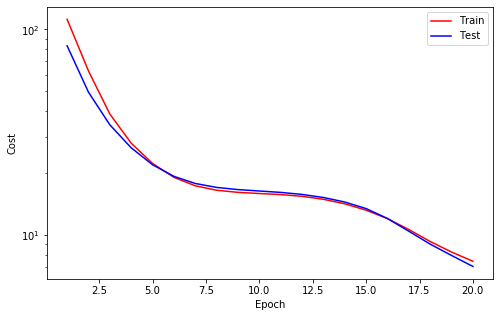



Epoch    21
Train_cost  = 6.6690 | Test_cost  = 6.2427 | 




Epoch    22
Train_cost  = 6.0375 | Test_cost  = 5.5952 | 




Epoch    23
Train_cost  = 5.5069 | Test_cost  = 5.0564 | 




Epoch    24
Train_cost  = 5.0661 | Test_cost  = 4.6100 | 




Epoch    25
Train_cost  = 4.6918 | Test_cost  = 4.2185 | 




Epoch    26
Train_cost  = 4.3676 | Test_cost  = 3.8794 | 




Epoch    27
Train_cost  = 4.0816 | Test_cost  = 3.5817 | 




Epoch    28
Train_cost  = 3.8238 | Test_cost  = 3.3135 | 




Epoch    29
Train_cost  = 3.5870 | Test_cost  = 3.0680 | 




Epoch    30
Train_cost  = 3.3650 | Test_cost  = 2.8404 | 




Epoch    31
Train_cost  = 3.1539 | Test_cost  = 2.6266 | 




Epoch    32
Train_cost  = 2.9512 | Test_cost  = 2.4243 | 




Epoch    33
Train_cost  = 2.7548 | Test_cost  = 2.2312 | 




Epoch    34
Train_cost  = 2.5627 | Test_cost  = 2.0458 | 




Epoch    35
Train_cost  = 2.3748 | Test_cost  = 1.8694 | 




Epoch    36
Train_cost  = 2.1927 | Test_cost  = 1.7034 | 




Epoch    37
Train_cost  = 2.0187 | Test_cost  = 1.5479 | 




Epoch    38
Train_cost  = 1.8555 | Test_cost  = 1.4063 | 




Epoch    39
Train_cost  = 1.7112 | Test_cost  = 1.2832 | 




Epoch    40
Train_cost  = 1.5900 | Test_cost  = 1.1785 | 


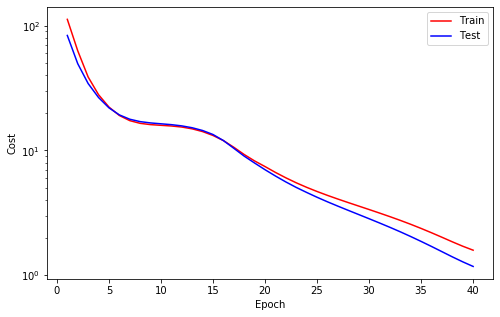



Epoch    41
Train_cost  = 1.4910 | Test_cost  = 1.0899 | 




Epoch    42
Train_cost  = 1.4092 | Test_cost  = 1.0129 | 




Epoch    43
Train_cost  = 1.3389 | Test_cost  = 0.9452 | 




Epoch    44
Train_cost  = 1.2769 | Test_cost  = 0.8854 | 




Epoch    45
Train_cost  = 1.2212 | Test_cost  = 0.8330 | 




Epoch    46
Train_cost  = 1.1712 | Test_cost  = 0.7870 | 




Epoch    47
Train_cost  = 1.1262 | Test_cost  = 0.7461 | 




Epoch    48
Train_cost  = 1.0854 | Test_cost  = 0.7090 | 




Epoch    49
Train_cost  = 1.0483 | Test_cost  = 0.6750 | 




Epoch    50
Train_cost  = 1.0141 | Test_cost  = 0.6443 | 




Epoch    51
Train_cost  = 0.9827 | Test_cost  = 0.6164 | 




Epoch    52
Train_cost  = 0.9538 | Test_cost  = 0.5909 | 




Epoch    53
Train_cost  = 0.9270 | Test_cost  = 0.5678 | 




Epoch    54
Train_cost  = 0.9023 | Test_cost  = 0.5465 | 




Epoch    55
Train_cost  = 0.8793 | Test_cost  = 0.5271 | 




Epoch    56
Train_cost  = 0.8580 | Test_cost  = 0.5093 | 




Epoch    57
Train_cost  = 0.8381 | Test_cost  = 0.4929 | 




Epoch    58
Train_cost  = 0.8196 | Test_cost  = 0.4779 | 




Epoch    59
Train_cost  = 0.8022 | Test_cost  = 0.4640 | 




Epoch    60
Train_cost  = 0.7860 | Test_cost  = 0.4512 | 


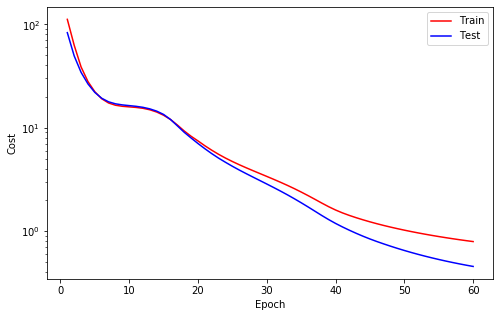



Epoch    61
Train_cost  = 0.7707 | Test_cost  = 0.4394 | 




Epoch    62
Train_cost  = 0.7564 | Test_cost  = 0.4285 | 




Epoch    63
Train_cost  = 0.7429 | Test_cost  = 0.4183 | 




Epoch    64
Train_cost  = 0.7301 | Test_cost  = 0.4089 | 




Epoch    65
Train_cost  = 0.7181 | Test_cost  = 0.4001 | 




Epoch    66
Train_cost  = 0.7067 | Test_cost  = 0.3920 | 




Epoch    67
Train_cost  = 0.6959 | Test_cost  = 0.3844 | 




Epoch    68
Train_cost  = 0.6856 | Test_cost  = 0.3774 | 




Epoch    69
Train_cost  = 0.6759 | Test_cost  = 0.3708 | 




Epoch    70
Train_cost  = 0.6666 | Test_cost  = 0.3646 | 




Epoch    71
Train_cost  = 0.6578 | Test_cost  = 0.3589 | 




Epoch    72
Train_cost  = 0.6494 | Test_cost  = 0.3535 | 




Epoch    73
Train_cost  = 0.6414 | Test_cost  = 0.3485 | 




Epoch    74
Train_cost  = 0.6337 | Test_cost  = 0.3438 | 




Epoch    75
Train_cost  = 0.6264 | Test_cost  = 0.3394 | 




Epoch    76
Train_cost  = 0.6194 | Test_cost  = 0.3353 | 




Epoch    77
Train_cost  = 0.6127 | Test_cost  = 0.3314 | 




Epoch    78
Train_cost  = 0.6063 | Test_cost  = 0.3278 | 




Epoch    79
Train_cost  = 0.6002 | Test_cost  = 0.3245 | 




Epoch    80
Train_cost  = 0.5943 | Test_cost  = 0.3213 | 


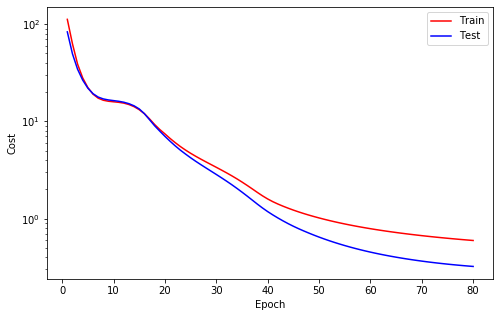



Epoch    81
Train_cost  = 0.5886 | Test_cost  = 0.3184 | 




Epoch    82
Train_cost  = 0.5832 | Test_cost  = 0.3156 | 




Epoch    83
Train_cost  = 0.5780 | Test_cost  = 0.3130 | 




Epoch    84
Train_cost  = 0.5729 | Test_cost  = 0.3106 | 




Epoch    85
Train_cost  = 0.5681 | Test_cost  = 0.3083 | 




Epoch    86
Train_cost  = 0.5634 | Test_cost  = 0.3062 | 




Epoch    87
Train_cost  = 0.5590 | Test_cost  = 0.3042 | 




Epoch    88
Train_cost  = 0.5546 | Test_cost  = 0.3023 | 




Epoch    89
Train_cost  = 0.5505 | Test_cost  = 0.3006 | 




Epoch    90
Train_cost  = 0.5464 | Test_cost  = 0.2990 | 




Epoch    91
Train_cost  = 0.5425 | Test_cost  = 0.2974 | 




Epoch    92
Train_cost  = 0.5388 | Test_cost  = 0.2960 | 




Epoch    93
Train_cost  = 0.5351 | Test_cost  = 0.2947 | 




Epoch    94
Train_cost  = 0.5316 | Test_cost  = 0.2935 | 




Epoch    95
Train_cost  = 0.5282 | Test_cost  = 0.2924 | 




Epoch    96
Train_cost  = 0.5249 | Test_cost  = 0.2914 | 




Epoch    97
Train_cost  = 0.5217 | Test_cost  = 0.2904 | 




Epoch    98
Train_cost  = 0.5186 | Test_cost  = 0.2895 | 




Epoch    99
Train_cost  = 0.5155 | Test_cost  = 0.2887 | 




Epoch   100
Train_cost  = 0.5126 | Test_cost  = 0.2880 | 


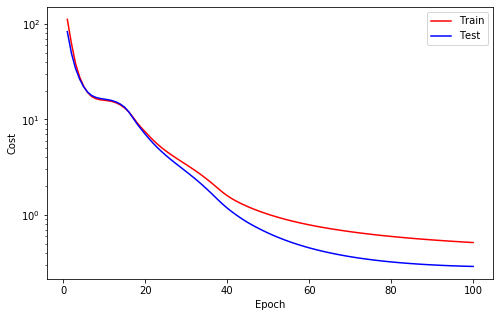



Epoch   101
Train_cost  = 0.5098 | Test_cost  = 0.2873 | 




Epoch   102
Train_cost  = 0.5071 | Test_cost  = 0.2866 | 




Epoch   103
Train_cost  = 0.5045 | Test_cost  = 0.2859 | 




Epoch   104
Train_cost  = 0.5020 | Test_cost  = 0.2852 | 




Epoch   105
Train_cost  = 0.4996 | Test_cost  = 0.2846 | 




Epoch   106
Train_cost  = 0.4973 | Test_cost  = 0.2840 | 




Epoch   107
Train_cost  = 0.4950 | Test_cost  = 0.2834 | 




Epoch   108
Train_cost  = 0.4928 | Test_cost  = 0.2829 | 




Epoch   109
Train_cost  = 0.4907 | Test_cost  = 0.2824 | 




Epoch   110
Train_cost  = 0.4886 | Test_cost  = 0.2819 | 




Epoch   111
Train_cost  = 0.4866 | Test_cost  = 0.2815 | 




Epoch   112
Train_cost  = 0.4846 | Test_cost  = 0.2811 | 




Epoch   113
Train_cost  = 0.4826 | Test_cost  = 0.2807 | 




Epoch   114
Train_cost  = 0.4808 | Test_cost  = 0.2804 | 




Epoch   115
Train_cost  = 0.4789 | Test_cost  = 0.2801 | 




Epoch   116
Train_cost  = 0.4771 | Test_cost  = 0.2798 | 




Epoch   117
Train_cost  = 0.4754 | Test_cost  = 0.2795 | 




Epoch   118
Train_cost  = 0.4737 | Test_cost  = 0.2792 | 




Epoch   119
Train_cost  = 0.4720 | Test_cost  = 0.2790 | 




Epoch   120
Train_cost  = 0.4704 | Test_cost  = 0.2788 | 


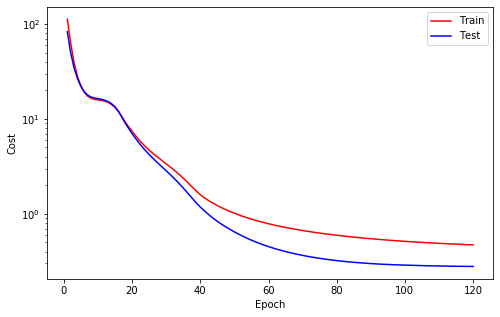



Epoch   121
Train_cost  = 0.4688 | Test_cost  = 0.2786 | 




Epoch   122
Train_cost  = 0.4672 | Test_cost  = 0.2784 | 




Epoch   123
Train_cost  = 0.4657 | Test_cost  = 0.2782 | 




Epoch   124
Train_cost  = 0.4642 | Test_cost  = 0.2781 | 




Epoch   125
Train_cost  = 0.4628 | Test_cost  = 0.2779 | 




Epoch   126
Train_cost  = 0.4614 | Test_cost  = 0.2778 | 




Epoch   127
Train_cost  = 0.4600 | Test_cost  = 0.2776 | 




Epoch   128
Train_cost  = 0.4586 | Test_cost  = 0.2775 | 




Epoch   129
Train_cost  = 0.4573 | Test_cost  = 0.2774 | 




Epoch   130
Train_cost  = 0.4560 | Test_cost  = 0.2772 | 




Epoch   131
Train_cost  = 0.4547 | Test_cost  = 0.2771 | 




Epoch   132
Train_cost  = 0.4535 | Test_cost  = 0.2770 | 




Epoch   133
Train_cost  = 0.4522 | Test_cost  = 0.2769 | 




Epoch   134
Train_cost  = 0.4510 | Test_cost  = 0.2767 | 




Epoch   135
Train_cost  = 0.4499 | Test_cost  = 0.2766 | 




Epoch   136
Train_cost  = 0.4487 | Test_cost  = 0.2765 | 




Epoch   137
Train_cost  = 0.4476 | Test_cost  = 0.2763 | 




Epoch   138
Train_cost  = 0.4465 | Test_cost  = 0.2762 | 




Epoch   139
Train_cost  = 0.4454 | Test_cost  = 0.2761 | 




Epoch   140
Train_cost  = 0.4443 | Test_cost  = 0.2759 | 


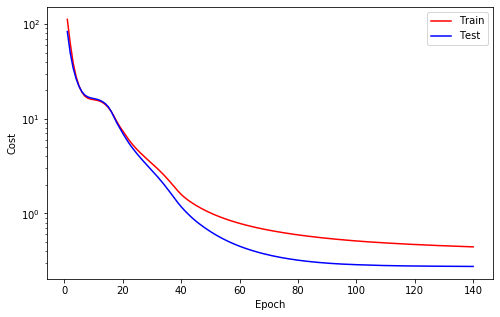



Epoch   141
Train_cost  = 0.4432 | Test_cost  = 0.2758 | 




Epoch   142
Train_cost  = 0.4422 | Test_cost  = 0.2756 | 




Epoch   143
Train_cost  = 0.4412 | Test_cost  = 0.2755 | 




Epoch   144
Train_cost  = 0.4402 | Test_cost  = 0.2754 | 




Epoch   145
Train_cost  = 0.4392 | Test_cost  = 0.2752 | 




Epoch   146
Train_cost  = 0.4382 | Test_cost  = 0.2751 | 




Epoch   147
Train_cost  = 0.4372 | Test_cost  = 0.2749 | 




Epoch   148
Train_cost  = 0.4362 | Test_cost  = 0.2748 | 




Epoch   149
Train_cost  = 0.4353 | Test_cost  = 0.2747 | 




Epoch   150
Train_cost  = 0.4343 | Test_cost  = 0.2746 | 




Epoch   151
Train_cost  = 0.4334 | Test_cost  = 0.2745 | 




Epoch   152
Train_cost  = 0.4324 | Test_cost  = 0.2744 | 




Epoch   153
Train_cost  = 0.4315 | Test_cost  = 0.2743 | 




Epoch   154
Train_cost  = 0.4306 | Test_cost  = 0.2742 | 




Epoch   155
Train_cost  = 0.4297 | Test_cost  = 0.2742 | 




Epoch   156
Train_cost  = 0.4288 | Test_cost  = 0.2741 | 




Epoch   157
Train_cost  = 0.4279 | Test_cost  = 0.2741 | 




Epoch   158
Train_cost  = 0.4270 | Test_cost  = 0.2741 | 




Epoch   159
Train_cost  = 0.4261 | Test_cost  = 0.2741 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2741




Epoch   160
Train_cost  = 0.4252 | Test_cost  = 0.2742 | 


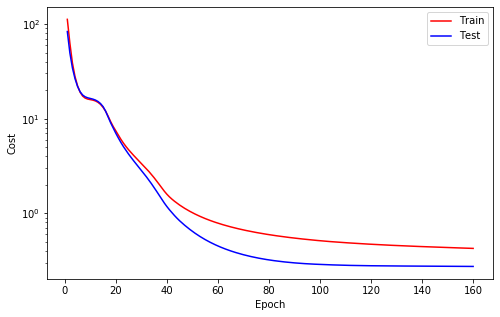

==> EarlyStop patience =  2 | Best test_cost: 0.2741




Epoch   161
Train_cost  = 0.4244 | Test_cost  = 0.2742 | 
==> EarlyStop patience =  3 | Best test_cost: 0.2741




Epoch   162
Train_cost  = 0.4235 | Test_cost  = 0.2743 | 
==> EarlyStop patience =  4 | Best test_cost: 0.2741




Epoch   163
Train_cost  = 0.4226 | Test_cost  = 0.2743 | 
==> EarlyStop patience =  5 | Best test_cost: 0.2741
==> Execute Early Stopping at epoch: 163 | Best test_cost: 0.2741
==> Best model is saved at model


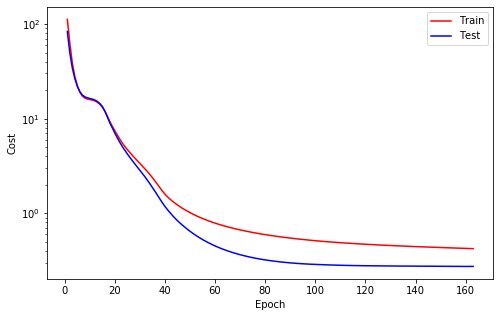

In [20]:
while True :
    train_cost= loop_fn("train",train_set,trainloader,model,criterion,optimizer,device)
    with torch.no_grad():
        test_cost= loop_fn("test",test_set,testloader,model,criterion,optimizer,device)

    callback.log(train_cost, test_cost)


    callback.save_checkpoint()


    callback.cost_runtime_plotting()



    if callback.early_stopping(model, monitor='test_cost'):
        callback.plot_cost()
        break

In [21]:
from luwiji.rnn import illustration

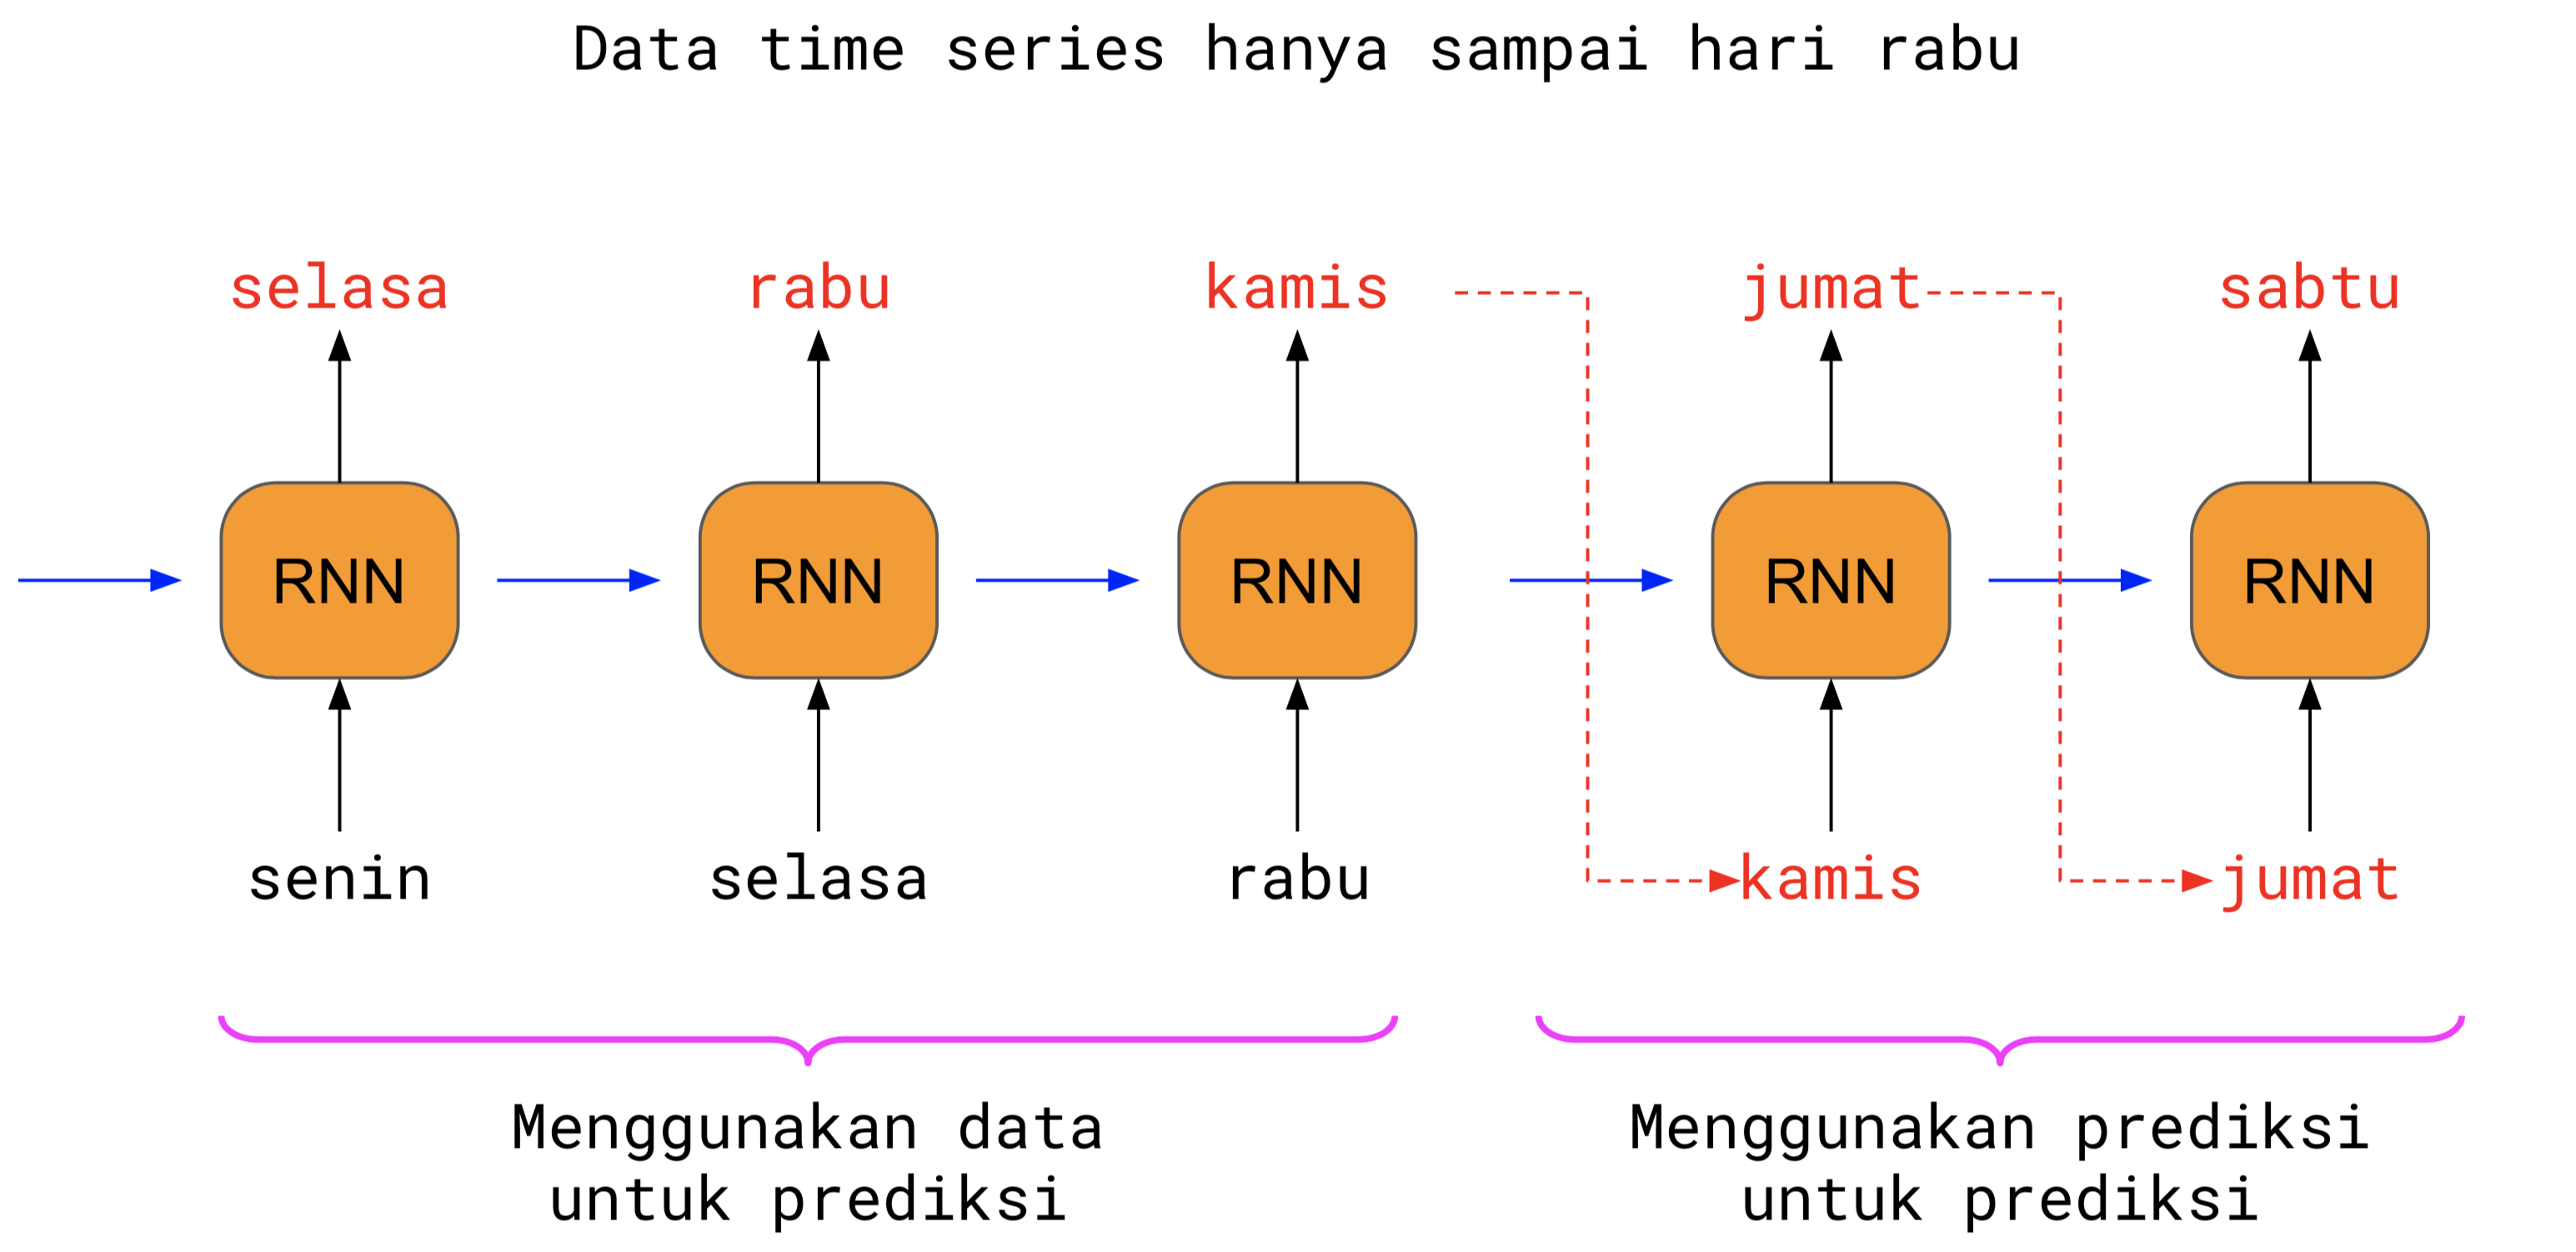

In [22]:
illustration.forecast

forcast untuk data time series itu sangat susah untuk diwujudkan dalam memprediksi dalam jangka panjang, karna apa? karna coba kita pahami illustrasi diatas, dimana pada saat training (menggunakan data untuk prediksi) model kita menggunakan data hari senin untuk memprediksi data hari selasa yang mana data hari selasa kita udah ada dalam dataset training kita, maka nya machine dapat memprediksi data yang ada (ya karna dia update weight, backprop, dll), tapi coba kita telaah lebih lanjut kalau misal nya kita hanya punya data yang dipelajari sampe hari rabu, kita coba untuk menggunakan insight dari data hari seni - rabu itu untuk memprediksi hari kamis dan selanjut nya, maka secara logika model machine kita akan kesusahan atau memiliki error prediksi yang tinggi, karna apa? karna informasi dari data data lalu (senin - rabu) itu gak terlalu bermakna, logika nya gini deh "kalau saya tau suhu di hari rabu, apakah saya bisa tau suhu di hari kamis? kemungkinan besar kita akan salah memprediksi nya" karna apa? karna informasi dari kita hanya mempelajari data data sebelum nya belum menjamin dapat memprediksi data data dikemudian hari selama nya. 
* maka dari itu kita perlu membuat data kita lebih bermakna, seperti kita bagi data misal nya berdasarkan quarter dalam satu tahun, maka itu setidak nya memberikan pola baru kepada machine dalam mempelajari pola.
* menggunakan metode pengembangan dari Recurrent Neural Network juga bisa menjadi solusi nya

In [23]:
from utils import data4pred,pred4pred

In [24]:
train_forecast_set = TimeSeriesDataset(ts_train,"Temp",1)
trainforcastloader= DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test,"Temp",1)
testforcastloader= DataLoader(test_forecast_set)



(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



C:\Users\Rahmat\anaconda3\envs\jcop\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'test')

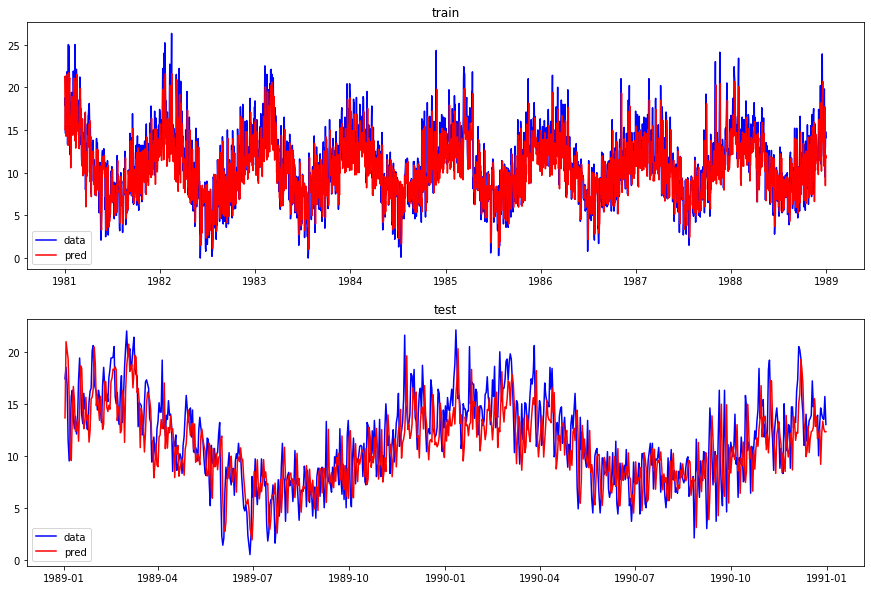

In [25]:
# data4pred
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model,train_forecast_set,trainforcastloader,device)
plt.title("train")


plt.subplot(212)
data4pred(model,test_forecast_set,testforcastloader,device)
plt.title("test")

Text(0.5, 1.0, 'test')

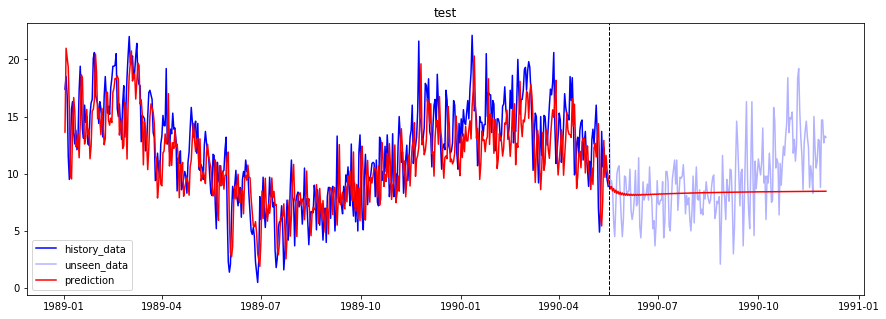

In [26]:
plt.figure(figsize=(15,5))

pred4pred(model,test_forecast_set,testforcastloader,device)
plt.title("test")